In [2]:
# Pipeline for combining all np.sum calculations for ePix Runs 14-17
# Last ran 08/08/2025

In [3]:
import numpy as np
import os
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [4]:
# Setup
runs = [14, 15, 16, 17]
file_template_general = "/sdf/group/rfar/timodo/ePix_Runs_ErrorPlot_Data/part0_run_{}.npz"
special_paths = {16: "/sdf/group/rfar/timodo/ePix_Runs_ErrorPlot_Data/part0_run_16_TEST.npz"}
file_paths = [special_paths.get(r, file_template_general.format(r)) for r in runs]
labels = [f'Run-{r}' for r in runs]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

In [5]:
def compute_errorbars_by_time(time, com):
    unique_times = np.unique(time)
    means = []
    stds = []
    for ut in unique_times:
        vals = com[time == ut]
        means.append(np.mean(vals))
        stds.append(np.std(vals))
    return unique_times, np.array(means), np.array(stds)

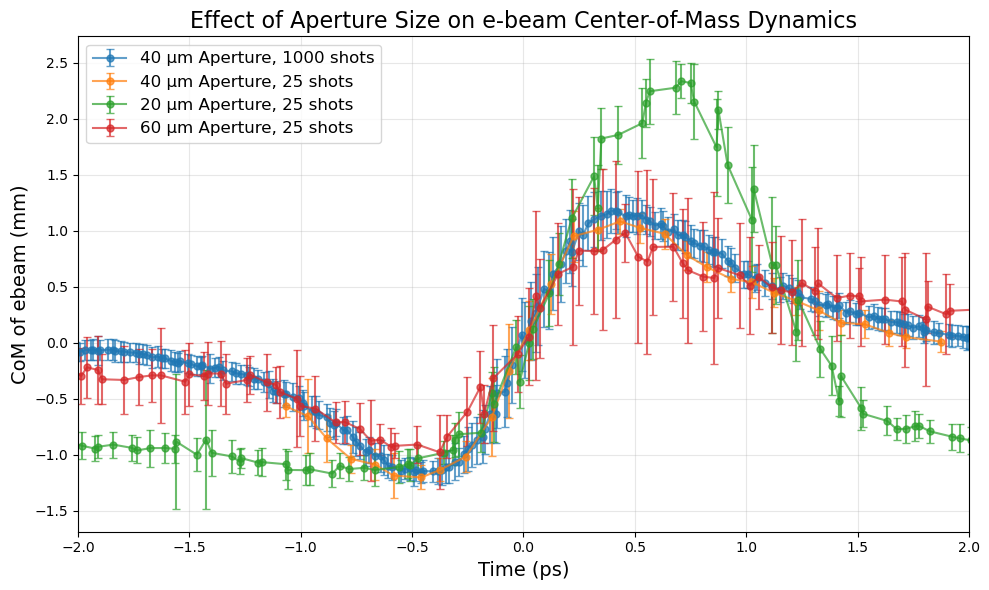

In [6]:
custom_labels = [
    "40 µm Aperture, 1000 shots",  # Run-14
    "40 µm Aperture, 25 shots",    # Run-15
    "20 µm Aperture, 25 shots",    # Run-16
    "60 µm Aperture, 25 shots"     # Run-17
]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

custom_time_shifts = [0.1e-12, 0.0, -0.45e-12, -1.41e-12]
custom_y_shifts    = [0.0, 0.0, -0.3, 0.0]

plt.figure(figsize=(10, 6))
for i, (run, file_path) in enumerate(zip(runs, file_paths)):
    data = np.load(file_path)
    time = data['t_part']
    if 'img_com_2_part_100um_inverted' in data:
        com = data['img_com_2_part_100um_inverted']
    elif 'img_com_2_part_100um' in data:
        com = data['img_com_2_part_100um']
    else:
        raise KeyError(f"No suitable CoM data in {file_path}")

    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)
    time_shifted = uniq_t + custom_time_shifts[i]
    mean_shifted = mean_vals + custom_y_shifts[i]
    # Convert time axis to picoseconds for plotting
    plt.errorbar(time_shifted / 1e-12, mean_shifted, yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=custom_labels[i], alpha=0.7, markersize=5)

plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('CoM of ebeam (mm)', fontsize=14)
plt.title('Effect of Aperture Size on e-beam Center-of-Mass Dynamics', fontsize=16)
plt.legend(fontsize=12)
plt.xlim(-2, 2)
plt.xticks(np.arange(-2, 2.5, 0.5))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

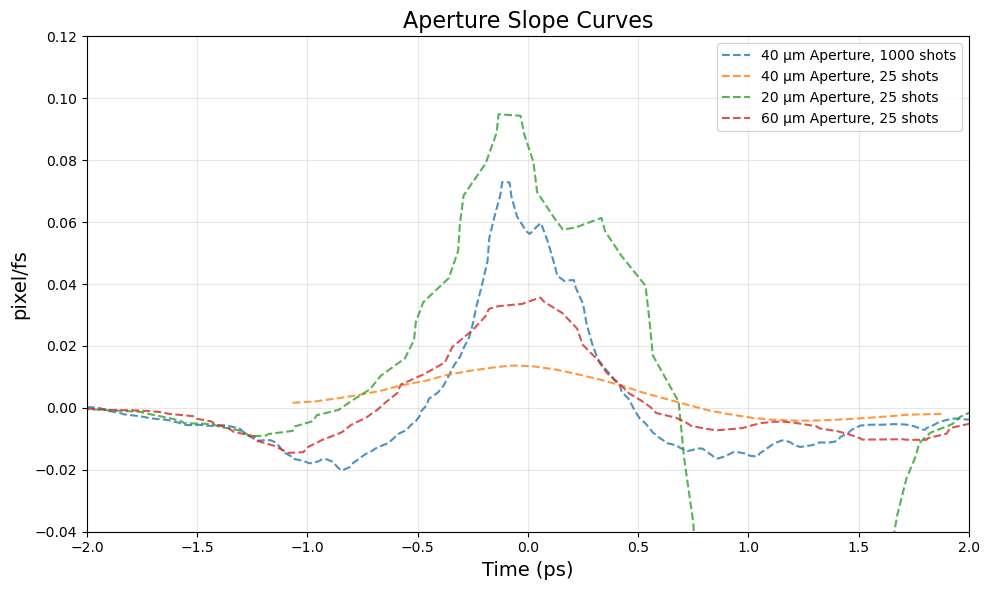

In [7]:
plt.figure(figsize=(10, 6))

custom_labels = [
    "40 µm Aperture, 1000 shots",  # Run-14
    "40 µm Aperture, 25 shots",    # Run-15
    "20 µm Aperture, 25 shots",    # Run-16
    "60 µm Aperture, 25 shots"     # Run-17
]

for i, (run, file_path) in enumerate(zip(runs, file_paths)):
    data = np.load(file_path)
    time = data['t_part']
    if 'img_com_2_part_100um_inverted' in data:
        com = data['img_com_2_part_100um_inverted']
    elif 'img_com_2_part_100um' in data:
        com = data['img_com_2_part_100um']
    else:
        raise KeyError(f"No suitable CoM data in {file_path}")

    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)
    time_shifted = uniq_t + custom_time_shifts[i]  # time in seconds
    mean_shifted = mean_vals + custom_y_shifts[i]  # CoM in mm
    
    from scipy.ndimage import gaussian_filter1d
    smoothed_mean = gaussian_filter1d(mean_shifted, sigma=5)  # Increased sigma for more smoothing
    
    # Calculate slope: d(CoM)/d(time) in mm/s
    slope_mm_per_s = np.gradient(smoothed_mean, time_shifted)
    
    # Also smooth the derivative itself for even smoother curves
    slope_mm_per_s_smooth = gaussian_filter1d(slope_mm_per_s, sigma=2)
    
    # Convert time to picoseconds for x-axis
    time_ps = time_shifted / 1e-12
    
    # Convert slope from mm/s to pixel/fs
    # 1 pixel = 0.1 mm → 10 pixels/mm
    # 1 s = 1e15 fs
    # slope(mm/s) × (10 pixels/mm) × (1 s/1e15 fs) = slope × 1e-14 pixel/fs
    slope_pixel_per_fs = slope_mm_per_s_smooth * 1e-14
    
    plt.plot(time_ps, slope_pixel_per_fs, '--', color=colors[i], 
             alpha=0.8, label=f'{custom_labels[i]}', linewidth=1.5)

plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('pixel/fs', fontsize=14)
plt.title('Aperture Slope Curves', fontsize=16)
plt.legend(fontsize=10, loc='upper right')
plt.xlim(-2, 2)
plt.ylim(-0.04, 0.12)
plt.xticks(np.arange(-2, 2.5, 0.5))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()